In [1]:
import torch as ch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
from tqdm import tqdm
import torchvision
from torchvision import transforms
from sklearn.neural_network import MLPClassifier
from joblib import dump, load
from tensorflow import keras
import os
from livelossplot import PlotLosses
import utils

In [2]:
def train_as_they_said(model, trainloader, testloader, lr, epochs):
    loss_fn = nn.BCEWithLogitsLoss(reduction='mean')
    def acc_fn(outputs, y): return ch.sum((y == (outputs >= 0)))

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    liveloss = PlotLosses()

    for _ in range(epochs):
        # Train
        running_loss, running_acc = 0.0, 0.0
        num_samples = 0
        model.train()
        for (x, y) in trainloader:
            x, y = x.cuda(), y.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(x)[:, 0]
            loss = loss_fn(outputs, y.float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.shape[0]
            running_acc += acc_fn(outputs, y)
            num_samples += x.shape[0]

        # Validation
        model.eval()
        running_loss_val, running_acc_val = 0.0, 0.0
        num_samples_val = 0
        with ch.no_grad():
            for (x, y) in testloader:
                x, y = x.cuda(), y.cuda()

                outputs = model(x)[:, 0]
                loss = loss_fn(outputs, y.float())
                running_loss_val += loss.item() * x.shape[0]
                running_acc_val += acc_fn(outputs, y)
                num_samples_val += x.shape[0]

        # Update metrics
        liveloss.update({'loss': running_loss / num_samples,
                         'acc': 100 * running_acc / num_samples,
                         'val_loss': running_loss_val / num_samples_val,
                         'val_acc': 100 * running_acc_val / num_samples_val})
        liveloss.send()
        
        # Update learning rate
        scheduler.step()

In [3]:
path = "/p/adversarialml/as9rw/datasets/celeba_raw_crop/splits/50_50/male/split_1/"
batch_size = 768
weightinit = "none" #"vggface2" #"none" (lr 1e-4, 13 epochs)

In [4]:
model = utils.FaceModel(512,
                        weight_init=weightinit,
                        train_feat=True,
                        hidden=[64, 16]).cuda()
model = nn.DataParallel(model)

In [5]:
# CelebA dataset
test_transforms = [
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
]
train_transforms = test_transforms[:]
augment_transforms = [transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), shear=0.2), transforms.RandomHorizontalFlip()]
train_transforms = augment_transforms + train_transforms
    
train_transform = transforms.Compose(train_transforms)
test_transform = transforms.Compose(test_transforms)

train_set = torchvision.datasets.ImageFolder(path + "/train",
                                            transform=train_transform)
test_set = torchvision.datasets.ImageFolder(path + "/test",
                                            transform=test_transform)
trainloader = ch.utils.data.DataLoader(train_set,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        pin_memory=True,
                                        num_workers=8)
testloader = ch.utils.data.DataLoader(test_set,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        num_workers=8)

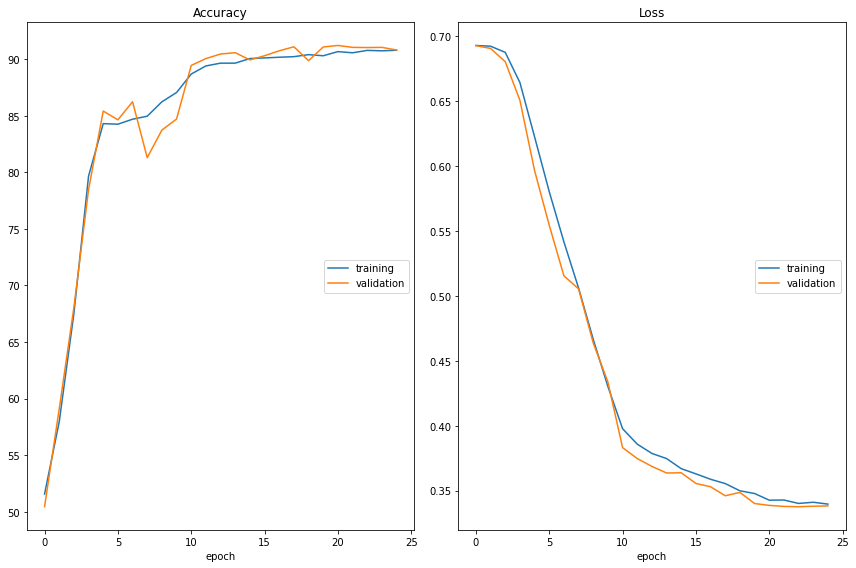

Accuracy
	training         	 (min:   51.564, max:   90.787, cur:   90.787)
	validation       	 (min:   50.445, max:   91.212, cur:   90.808)
Loss
	training         	 (min:    0.340, max:    0.693, cur:    0.340)
	validation       	 (min:    0.338, max:    0.693, cur:    0.338)


In [6]:
epochs = 25
lr = 1e-4
# lr = 1e-4 # Stop at 15

train_as_they_said(model, trainloader, testloader, lr, epochs)